## Introduction
```13-Feb-2024```

The following is an exploration of the collections of the [Library of Congress](https://www.loc.gov/collections/) via their API.

## Load Packages

We first load the required packages for this simple exploration.

_Note: As I'm from an R background, please confirm, shoud they be called packages or modules?_

In [1]:
### Import Packages

# Get and Manipulate Data
import requests
import json

# Display Images
from PIL import Image
from io import BytesIO

# Display Graph
import pandas as pd
%matplotlib inline
from collections import Counter
import math

## Create Helper Functions

We next create three helper functions which will be used throughout our exploration.

In [2]:
def get_val_from_json(collections_json, used_key, head_key = "results"):
    """Retrieves and returns values from a JSON file, handling pagination if present.

    Args:
        collections_json (json): The json to be searched, assume in the stucture of loc
        used_key (str): The key for the values to be returned

    Returns:
        list: A list of values or an empty list if the file is missing or corrupt.

    Raises:
        IOError: If the file cannot be opened.
        JSONDecodeError: If the JSON is invalid.
    """
    values = []
    while True:
        for collection in collections_json.get(head_key, []):
            value = collection.get(used_key)
            if value:
                values.append(value)

        next_page = collections_json.get("pagination", {}).get("next")
        if not next_page:
            break  # No more pages, exit loop

        try:
            collections_json = requests.get(next_page).json()
        except requests.exceptions.RequestException as e:
            print(f"Error fetching next page: {e}")
            break  # Handle exception and exit

    return values


#####


def explore_json_structure(data, seen_values=None):
    """

    Recursively explores the structure of a JSON-like object (dictionary or list).

    Args:
        data (json): The JSON-like object to explore.
        seen_values: Set to track seen values (optional).

    Returns:
        A representation of the structure (e.g., nested dictionaries or lists).
    """
    if seen_values is None:
        seen_values = set()
    if isinstance(data, dict):
        if len(data) == 1:
            key, value = next(iter(data.items()))
            return {key: explore_json_structure(value, seen_values)}
        else:
            return {key: explore_json_structure(value, seen_values) for key, value in data.items()}
    elif isinstance(data, list):
        if len(data) > 1:
            return [explore_json_structure(data[0], seen_values)]
        else:
            return [explore_json_structure(item, seen_values) for item in data]
    else:
        if data not in seen_values:
            seen_values.add(data)
            return "VALUE"
        else:
            return "VALUE"


#####


def roundup(x):
    """

    Round a number up to the nearest ten

    Args:
        x : The number to roundup
        seen_values: Set to track seen values (optional).

    Returns:
        The desired number rounded up.
    """
    return math.ceil(x / 10.0) * 10



## Data Prep

We now get the details of all the collections and display a simple json which helps us to see the overall structure of the document.

In [3]:
url = "https://www.loc.gov/collections/?fo=json"

collections_json = requests.get(url).json()

In [4]:
collections_simple_struct = explore_json_structure(collections_json)

print(json.dumps(collections_simple_struct, sort_keys=True, indent=2))

{
  "breadcrumbs": [
    {
      "Library of Congress": "VALUE"
    }
  ],
  "browse": {
    "facets": {
      "include": [
        {
          "field": "VALUE",
          "label": "VALUE"
        }
      ]
    },
    "sortBy": "VALUE",
    "style": "VALUE"
  },
  "categories": [
    "VALUE"
  ],
  "content": {
    "active": "VALUE",
    "link": "VALUE",
    "markup": "VALUE",
    "pagination": "VALUE",
    "partof": [],
    "results": [
      {
        "access_restricted": "VALUE",
        "aka": [
          "VALUE"
        ],
        "campaigns": [],
        "count": "VALUE",
        "description": [
          "VALUE"
        ],
        "digitized": "VALUE",
        "extract_timestamp": "VALUE",
        "group": [
          "VALUE"
        ],
        "hassegments": "VALUE",
        "id": "VALUE",
        "image_url": [
          "VALUE"
        ],
        "index": "VALUE",
        "items": "VALUE",
        "original_format": [
          "VALUE"
        ],
        "other_title": [],
 

Armed with our understanding of the json structure, we now collect the following into lists:
 - Title of the Collection
 - Cover image of the Collection
 - Link to the Collection's About Page
 - Description of the Collection
 - Number of items in the Collection

In [5]:
collections_titles = get_val_from_json(collections_json, "title")
collections_images = get_val_from_json(collections_json, "image_url")
collections_links = get_val_from_json(collections_json, "url")
collections_desc = get_val_from_json(collections_json, "description")
collections_count = get_val_from_json(collections_json, "count")

In [6]:
print("The following is a sanity check where all the values listed below should be equal.\n")
print(f"They are {len(collections_titles)} collections in the Library of Congress")
print(f"These collections have a total of {len(collections_images)} images across them")
print(f"These collections have a total of {len(collections_links)} main links across them")
print(f"These collections have a total of {len(collections_desc)} descriptions across them")
print(f"These collections have a total of {len(collections_count)} counts of items")

The following is a sanity check where all the values listed below should be equal.

They are 524 collections in the Library of Congress
These collections have a total of 524 images across them
These collections have a total of 524 main links across them
These collections have a total of 524 descriptions across them
These collections have a total of 524 counts of items


We lastly create a function which we will use to query any single collection and return some information about it.

In [7]:
def show_collection(id, n = 50):
    print(f"Title: {collections_titles[id]}")
    print(f"Link: {collections_links[id]}")
    display(Image.open(BytesIO(requests.get(collections_images[id][0]).content)))
    print(collections_desc[id][0])
    print("\n\n\n")
    ###
    list_cnt = roundup(collections_count[id])
    collection_json_url = collections_links[id].replace("about-this-collection/", f"?st=list&c={list_cnt}&fo=json&at=results")
    print(f"JSON Link: {collection_json_url}")
    ###
    subject_counter = Counter()
    collection_json = requests.get(collection_json_url).json()
    for item in collection_json["results"]:
        if "subject" in item and item["subject"] is not None:
            for subject in item["subject"]:
                subject_counter[subject] += 1
    ###
    print(f"Items in Collection: {collections_count[id]}")
    print(f"Unique Number of Subjects: {len(subject_counter)}")
    ###
    if n > len(subject_counter):
        top_v = len(subject_counter)
    else:
        top_v = n
    print(f"\nPlot Showing Count of Top {top_v} Subjects in Collection")
    subjects = pd.Series(subject_counter)
    top_n_subjects = subjects.nlargest(n)
    top_n_subjects.sort_values(ascending=True).plot(kind='barh', figsize=(12,12))
    ###


    



# Analysis of Single Collection

Finally we run our analysis.
Feel free to change the number in the function, each number is a reference to one of the collections.

You may see which number matches which collection in the appendix.

_Bear in mind, this still isn't perfect as some collections have so many items that we are unable to capture all the unique subjects.
As such you may enter a second number in the function which limits the amount of subjects shown, currently it is set to 50 as a default._


Title: Selected Datasets
Link: https://www.loc.gov/collections/selected-datasets/about-this-collection/


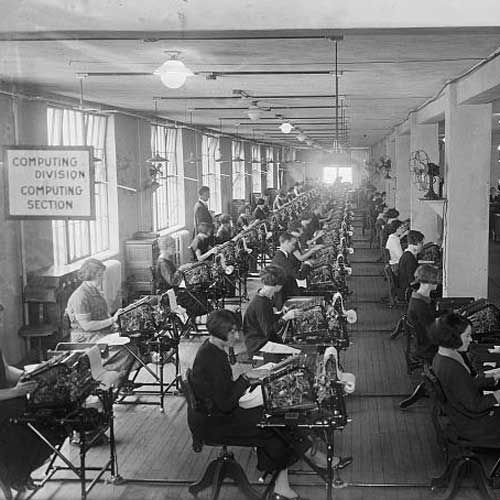

Datasets are increasingly a key digital resource used in a wide range of fields. The Library of Congress selects, preserves, and provides enduring access to datasets with the goal of cultivating a broad collection that encompasses all the areas covered by Library of Congress Collection Policy Statements. For more information on priorities for collecting datasets, see the Supplementary Guidelines for Datasets. Additional datasets acquired by the Library for the permanent collection will be made available here on a regular basis.




JSON Link: https://www.loc.gov/collections/selected-datasets/?st=list&c=140&fo=json&at=results
Items in Collection: 140
Unique Number of Subjects: 454

Plot Showing Count of Top 50 Subjects in Collection


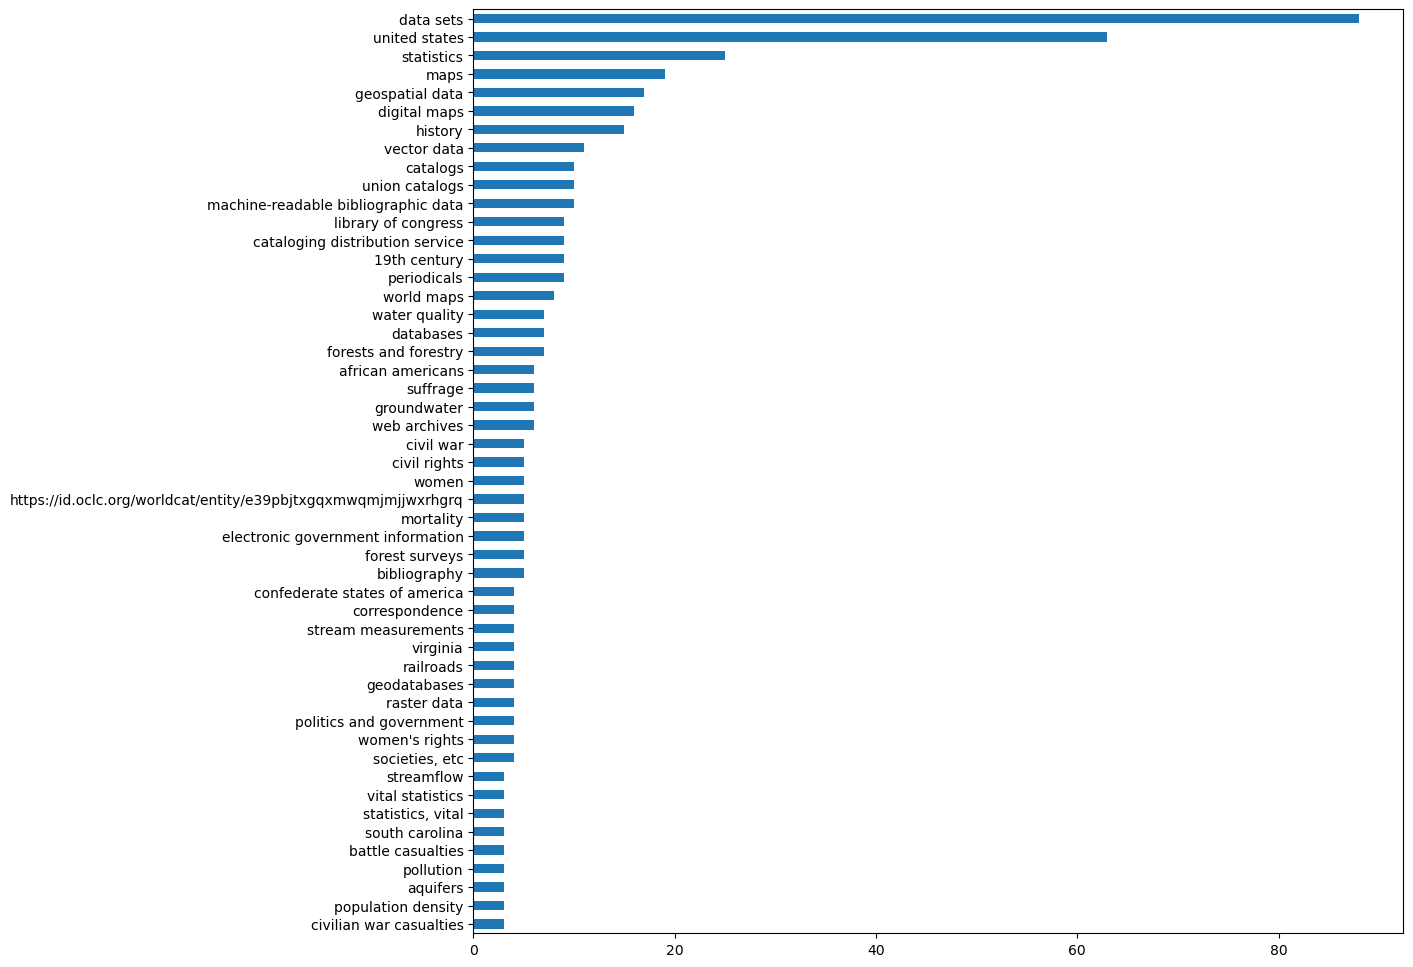

In [8]:
show_collection(414)

## Appendix

You may use the below list to find which ID to use to pull the information you're interested in.

In [12]:
for i, item in enumerate(collections_titles):
    print(f"{i} - {item}")

0 - 10th-16th Century Liturgical Chants
1 - A.P. Schmidt Company archives, 1869-1958
2 - Aaron Copland Collection
3 - Abdul Hamid II Collection
4 - Abdul-Hamid II Collection of Books and Serials Gifted to the Library of Congress
5 - Abraham Lincoln Papers at the Library of Congress
6 - Afghanistan Web Archive
7 - Afghanistan, Iran, Pakistan and Tajikistan Government Web Archive
8 - Afghanistan, Iran, Pakistan, and Tajikistan Elections Web Archive
9 - African American Perspectives: Materials Selected from the Rare Book Collection
10 - African American Photographs Assembled for 1900 Paris Exposition
11 - African Government Web Archive
12 - African-American Band Music & Recordings, 1883-1923
13 - Africana Historic Postcard Collection
14 - After the Day of Infamy: "Man-on-the-Street" Interviews Following the Attack on Pearl Harbor
15 - Ainu and Ezochi Rare Collection
16 - Alan Lomax Collection
17 - Alan Lomax Collection of Michigan and Wisconsin Recordings
18 - Albert Schatz Collection
19 